In [ ]:
! pip install transformers
! pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd, numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import random
import ast
from collections import defaultdict
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
import scipy
import tensorflow as tf
from implicit import bpr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from PIL import Image
import requests
from io import BytesIO
from collections import Counter

In [ ]:
# Check whether GPU is available and can be used
# if CUDA is found then device is set accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    print("Consider changing your run-time to GPU or training will be slow.")

In [ ]:
df = pd.read_csv('data/cleaned_df.csv')


In [ ]:
df['cat'] = df['cat'].apply(lambda x: ast.literal_eval(x))

In [ ]:
interactions = []
ratingDict = {}
for index, d in df.iterrows():
  interactions.append((d['reviewerID'],d['asin'], 1))  #d['overall']
  ratingDict[(d['reviewerID'],d['asin'])] = d['overall']
interactions[0]

('A1TBWRXV7KVHPC', '0000031887', 1)

In [ ]:
userIDs,itemIDs = {},{}

for u,i,r in tqdm(interactions):
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

100%|██████████| 1099170/1099170 [00:00<00:00, 1775505.66it/s]


In [ ]:
items = df['asin'].unique()
users = df['reviewerID'].unique()

In [ ]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)

itemsSetPerUser = defaultdict(set)
usersSetPerItem = defaultdict(set)

for u,i,r in interactions:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

    itemsSetPerUser[u].add(i)
    usersSetPerItem[i].add(u)

allItems = list(usersPerItem.keys())
allUsers = list(itemsPerUser.keys())

In [ ]:


# Assuming 'df' is your DataFrame and 'cat' is the column with sets of categories
category_counts = Counter()

for categories in df['cat']:

    category_counts.update(categories)

# Now category_counts has the occurrences of each category

In [ ]:
# Select the top 1000 categories

# Remove the empty category
top_1000_categories = {category for category, count in category_counts.most_common(1001)}.difference({''})
len(top_1000_categories)

1000

In [ ]:
df['user_id'] = df['reviewerID'].apply(lambda r : userIDs[r])

In [ ]:

def convert_to_category_index(categories, top_categories):
    """
    Convert a set of categories to their corresponding indices within a list of top categories.

    :param categories: Set of categories to convert.
    :param top_categories: List of top categories.

    :return: List of indices corresponding to the positions of matched categories in the top categories list.
    """
    result_list = []
    for i, category in enumerate(top_categories):
        if category in categories:
            result_list.append(i)
    return result_list

def convert_to_embedding(categories, top_categories):
    """
    Convert a set of categories to a binary embedding array.

    :param categories: Set of categories to convert.
    :param top_categories: List of top categories.

    :return: Binary array representing the presence (1) or absence (0) of each category in the top categories list.
    """
    return np.array([int(category in categories) for category in top_categories])


In [ ]:
df['category_indices'] = df['cat'].apply(lambda categories: convert_to_category_index(categories, top_1000_categories))

In [ ]:
df.sort_values(by=['user_id','unixReviewTime'], inplace=True)

In [ ]:
user_categories_arr = df[['user_id','category_indices']].values

In [ ]:
user_category_series = {}
current_user_id = 0
start_index = 0
seq = []

for i, row in enumerate(user_categories_arr):
    user_id, category_indices = row[0], row[1]

    if user_id != current_user_id:
        user_category_series[current_user_id] = seq
        current_user_id = user_id
        seq = []
        start_index = i

    seq.append(category_indices)

if current_user_id is not None:
    user_category_series[current_user_id] = seq

In [ ]:
loaded_data = np.load('data/embedding_array.npz')
embedding_arr = loaded_data['embedding_arr']
embedding_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
class LSTM(nn.Module):

    def __init__(self, embedding_length, output_size, device, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()

        self.device = device
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        # define the LSTM
        self.lstm = nn.LSTM(embedding_length, n_hidden, n_layers, dropout=drop_prob, batch_first=True)

        # define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, output_size)

    def forward(self, x, hidden):
        ''' 
        Forward pass through the network.
        The inputs are x, and the hidden & cell state in a tuple. 
        '''

        # get the outputs and the new hidden states from the LSTM
        r_output, hidden = self.lstm(x, hidden)

        # pass through a dropout layer
        out = self.dropout(r_output)

        # Select the output of the last timestep for each sequence in the batch
        # Assuming out has shape [batch_size, seq_length, n_hidden]
        last_output = out[:, -1, :]  # This selects the last element from the second dimension (seq_length)

        # Calculate fully connected layer output
        out = self.fc(last_output)

        return out, hidden


    def init_hidden(self, batch_size=1):
        ''' 
        Initializes hidden state 
        '''
        # Create new tensors for LSTM hidden and cell states, initialized to zero
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(self.device))
        return hidden

In [ ]:
modelLSTM = torch.load('/content/drive/MyDrive/CSE158 a2/Colab Notebooks/LSTM.pth')
modelLSTM.eval()

LSTM(
  (lstm): LSTM(1000, 512, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)

In [ ]:
def get_embedding_from_cat_list(cat_list):
    return [int(i in cat_list) for i in range(1000)]


In [ ]:
def pred_cat(X):
    """
    Generate predictions using an LSTM model for a given input sequence.
    """
    # Initialize the LSTM hidden state for each function call
    hidden = modelLSTM.init_hidden(batch_size=1)  # Adjust batch_size as needed

    predictions = []
    with torch.no_grad():
        for x in X:
            input = torch.from_numpy(x).float().view(1, 1, -1).to(modelLSTM.device)
            out, hidden = modelLSTM(input, hidden)

    return out


In [ ]:
df['category_indices'] = df['cat'].apply(lambda categories: convert_to_category_index(categories, top_1000_categories))

In [ ]:
df.sort_values(by=['user_id','unixReviewTime'], inplace=True)

In [ ]:
user_categories_arr = df[['user_id','category_indices']].values

In [ ]:
user_category_series = {}
current_user_id = 0
start_index = 0
seq = []

for i, row in enumerate(user_categories_arr):
    user_id, category_indices = row[0], row[1]

    if user_id != current_user_id:
        user_category_series[current_user_id] = seq
        current_user_id = user_id
        seq = []
        start_index = i

    seq.append(category_indices)

if current_user_id is not None:
    user_category_series[current_user_id] = seq

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [ ]:
def get_relevance_score(history_cat_seq):
  pred = pred_cat(history_cat_seq).to('cpu').numpy().flatten()
  dot_product = np.dot(pred, embedding_arr.T)
  relevance_score = standardize(dot_product)
  return relevance_score

In [ ]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        # return self.lamb * (tf.reduce_sum(tf.abs(self.betaU)) +\
        #                     tf.reduce_sum(tf.abs(self.betaI)) +\
        #                     tf.reduce_sum(self.gammaU**2) +\
        #                     tf.reduce_sum(self.gammaI**2))

        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                    tf.reduce_sum(self.betaI**2) +\
                    tf.reduce_sum(self.gammaU**2) +\
                    tf.reduce_sum(self.gammaI**2))

    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred

    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)

        # Calculate Mean Squared Error (MSE)
        mse_loss = tf.nn.l2_loss(pred - r) / len(sampleR)

        # Calculate regularization term using the reg() method
        reg_term = self.reg()

        # Combine MSE loss and regularization term
        total_loss = mse_loss + reg_term

        return total_loss

In [ ]:

# To load the entire model including architecture, optimizer state, and weights:
modelLFM = LatentFactorModel(0.11593933461555825, 100, 1e-5)
loaded_model = modelLFM.load_weights('models/latent_factor_model_weights')

In [ ]:
def get_unexpectedness_score(user_id):
    user_vecs = modelLFM.gammaU.numpy()
    item_vecs = modelLFM.gammaI.numpy()
    item_bi = modelLFM.betaI.numpy().reshape(-1)
    rec_vector = np.add(user_vecs[user_id, :].dot(item_vecs.T), item_bi)
    relevance_score = standardize(rec_vector)
    return relevance_score

In [ ]:
itemImgDict = dict(zip(df['asin'], df['imUrl']))
itemNameDict = dict(zip(df['asin'], df['title']))

In [ ]:
def print_item_image(item):
    try:
        # Retrieve the image URL from the dictionary
        img_url = itemImgDict[item]
        # Send an HTTP GET request to the image URL
        response = requests.get(img_url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Read the image content from the response
            img_data = BytesIO(response.content)

            # Open the image using PIL (Pillow)
            img = Image.open(img_data)

            # Display the image
            display(img)
        else:
            print(f"Failed to retrieve image. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [ ]:
def display_item_images(item_ids, grid_dims=(2, 5)):
    """
    Displays a grid of item images.

    :param item_ids: List of item IDs.
    :param itemImgDict: Dictionary mapping item IDs to image URLs.
    :param itemNameDict: Dictionary mapping item IDs to item titles.
    :param grid_dims: Dimensions of the grid (rows, columns).
    """

    def truncate_title(title, max_length=30):
        """
        Truncates the title if it is too long and adds a newline character for better formatting.

        :param title: The title to truncate.
        :param max_length: Maximum length of the title.

        :return: Truncated title.
        """
        if pd.isnull(title): return ""
        if len(title) > max_length:
            return title[:max_length] + "-\n" + title[max_length:max_length * 2] + ("..." if len(title) > max_length * 2 else "")
        return title

    # Create subplots
    fig, axes = plt.subplots(*grid_dims, figsize=(12, 6))
    axes = axes.flatten()

    for ax, item_id in zip(axes, item_ids):

        if item_id in itemImgDict:
            # Retrieve image from URL

            if pd.isnull(itemImgDict[item_id]):
                ax.set_title(truncate_title(itemNameDict[item_id]), fontsize=10)  # Adjust font size
                ax.axis('off')
                ax.title.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))  # Set title background
                continue

            response = requests.get(itemImgDict[item_id])

            img = Image.open(BytesIO(response.content))

            # Display the image
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(truncate_title(itemNameDict[item_id]), fontsize=10)  # Adjust font size
            ax.title.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))  # Set title background
        else:
            ax.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()



In [ ]:
Xui = scipy.sparse.lil_matrix((nUsers, nItems))
for u,i,r in interactions:
    Xui[userIDs[u],itemIDs[i]] = r

Xui_csr = scipy.sparse.csr_matrix(Xui)

In [ ]:
modelBPR = bpr.BayesianPersonalizedRanking(factors = 100)

In [ ]:
modelBPR.fit(Xui_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

[-0.2126526  -0.21468176 -0.21468176 ... -1.02519653 -1.22146488
  0.03387238]
[236633 173146 204987 274440 180259 163575 164196 150304 124727 186141]
[14.49596736 14.49596736 14.09730028 14.39775369 14.39775369 14.39775369
 14.39775369 14.53945646 14.49596736 14.49596736]
[3.8906512 3.1261046 3.2028646 2.6794395 2.578612  2.4795406 2.3813038
 2.11027   2.1188653 1.9952798]


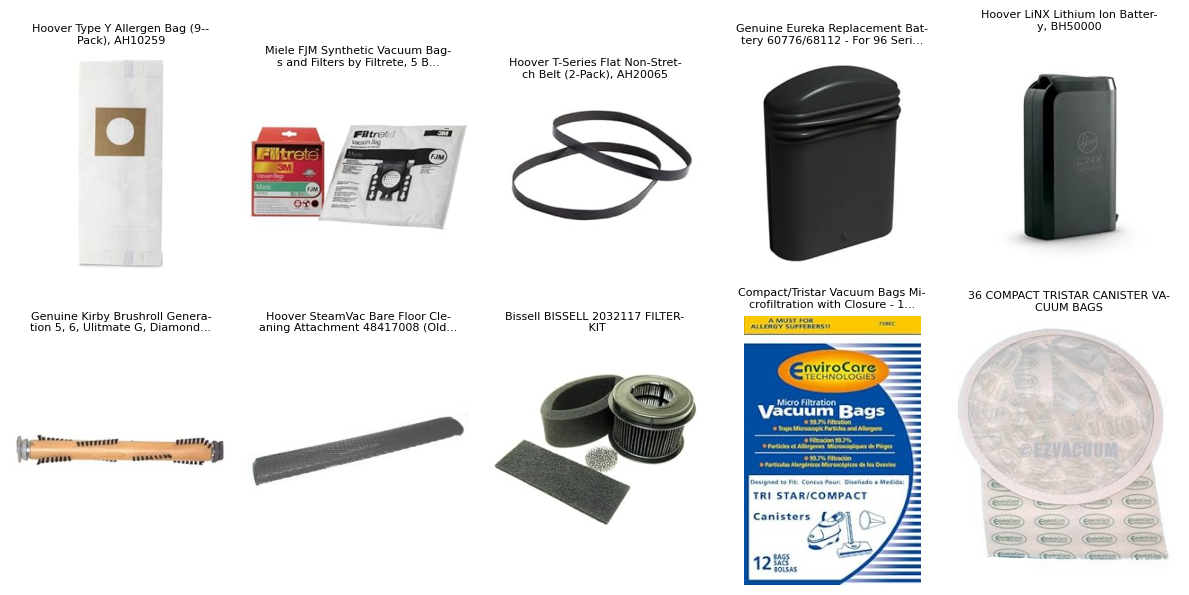

In [ ]:
user_id = 1083
lamb = 1
cat_sequence = []
for cat in user_category_series[user_id]:
    cat_sequence.append(get_embedding_from_cat_list(cat))
cat_sequence = np.array(cat_sequence)

X = cat_sequence[:-1,:]
y = cat_sequence[-1,:]

R = get_relevance_score(X)
print(R)
U = get_unexpectedness_score(user_id)

S = R + lamb * U

top_10_indices = np.argpartition(S, -10)[-10:]

# Sort the top indices based on values
top_10_indices_sorted = top_10_indices[np.argsort(S[top_10_indices])][::-1]

print(top_10_indices_sorted)

print(R[top_10_indices_sorted])
print(U[top_10_indices_sorted])

display_item_images([items[i] for i in top_10_indices_sorted])

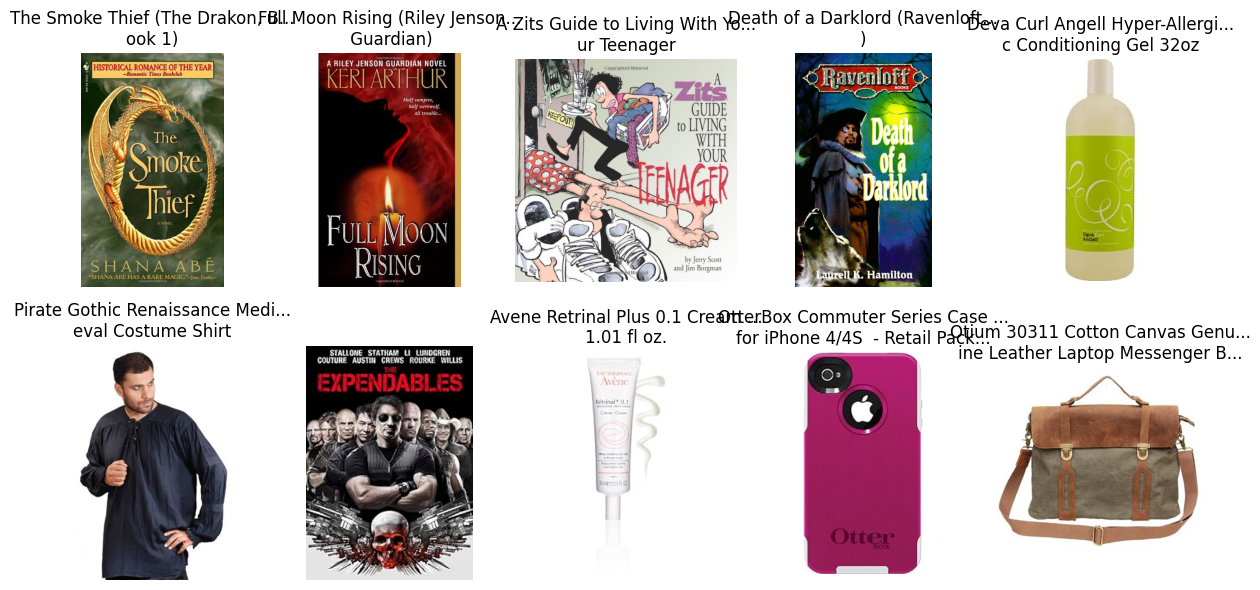

In [ ]:
user_id = 1083
purchase_history = itemsPerUser[users[user_id]][-10:]
display_item_images(purchase_history)

In [ ]:
def recommend(model, user):
  """
  Recommends items to a user based on their purchase history using specified recommendation model.

  :param user: The username for whom recommendations are generated.
  :param model: specified model
  :display: 
  - The user's last 10 purchased items.
  - The top 10 recommended items based on the user's history and the recommendation model.
  """
  print(f"User {user}'s last 10 purchased items: ")
  purchase_history = itemsPerUser[user][-10:]
  display_item_images(purchase_history)

  print("#" * 100)

  print(f"The top 10 recommended items: ")
  recommended = model.recommend(userIDs[user], Xui_csr[userIDs[user]], 10)
  item_ids =  [items[item_id] for item_id in recommended[0]]
  display_item_images(item_ids)

In [ ]:
def recommend_Sere(user_id, lamb = 0.1, visual=False):
    """
    Recommends items to a user based on their purchase history using unexpected scores, relevance scores and a balancing factor
    :param user_id: Identifier for a user
    :param lamb: Balancing factor
    :param visual: whether to display the top_10 recommended items

    :return: sorted list of indices of the top_10 recommended items
    """
    cat_sequence = []
    for cat in user_category_series[user_id]:
        cat_sequence.append(get_embedding_from_cat_list(cat))
    cat_sequence = np.array(cat_sequence)

    X = cat_sequence[:-1,:]
    y = cat_sequence[-1,:]

    R = get_relevance_score(X)
    U = get_unexpectedness_score(user_id)

    S = R + lamb * U

    top_10_indices = np.argpartition(S, -10)[-10:]

    # Sort the top indices based on values
    top_10_indices_sorted = top_10_indices[np.argsort(S[top_10_indices])][::-1]

    if visual:
        print(f"User {users[user_id]}'s last 10 purchased items: ")
        purchase_history = itemsPerUser[users[user_id]][-10:]
        display_item_images(purchase_history)

        print("#" * 100)

        print(f"The top 10 recommended items: ")

        item_ids =  [items[item_id] for item_id in top_10_indices_sorted]

        display_item_images(item_ids)


    return top_10_indices_sorted

def recommend_Base(user_id, visual=False):
    """
    Recommends items using only the base model (BPR)
    """
    recommended = modelBPR.recommend(user_id, Xui_csr[user_id], 10)[0]

    if visual:
        print(f"User {users[user_id]}'s last 10 purchased items: ")
        purchase_history = itemsPerUser[users[user_id]][-10:]
        display_item_images(purchase_history)

        print("#" * 100)

        print(f"The top 10 recommended items: ")

        item_ids =  [items[item_id] for item_id in recommended]

        display_item_images(item_ids)

    return recommended

User A2BNKCBBUAYAUT's last 10 purchased items: 


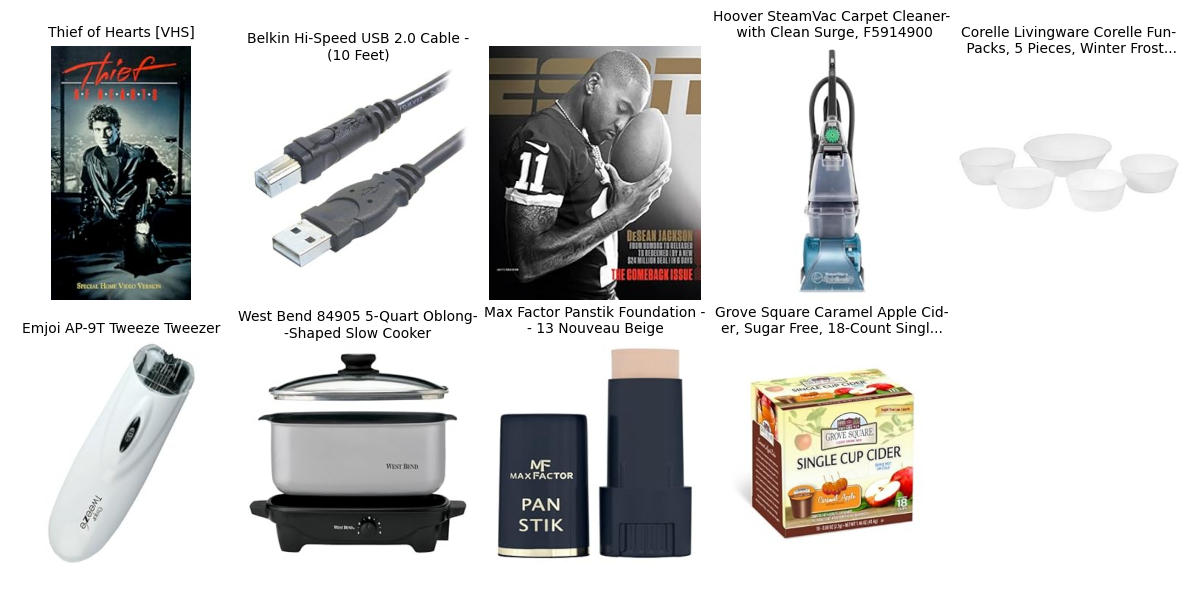

####################################################################################################
The top 10 recommended items: 


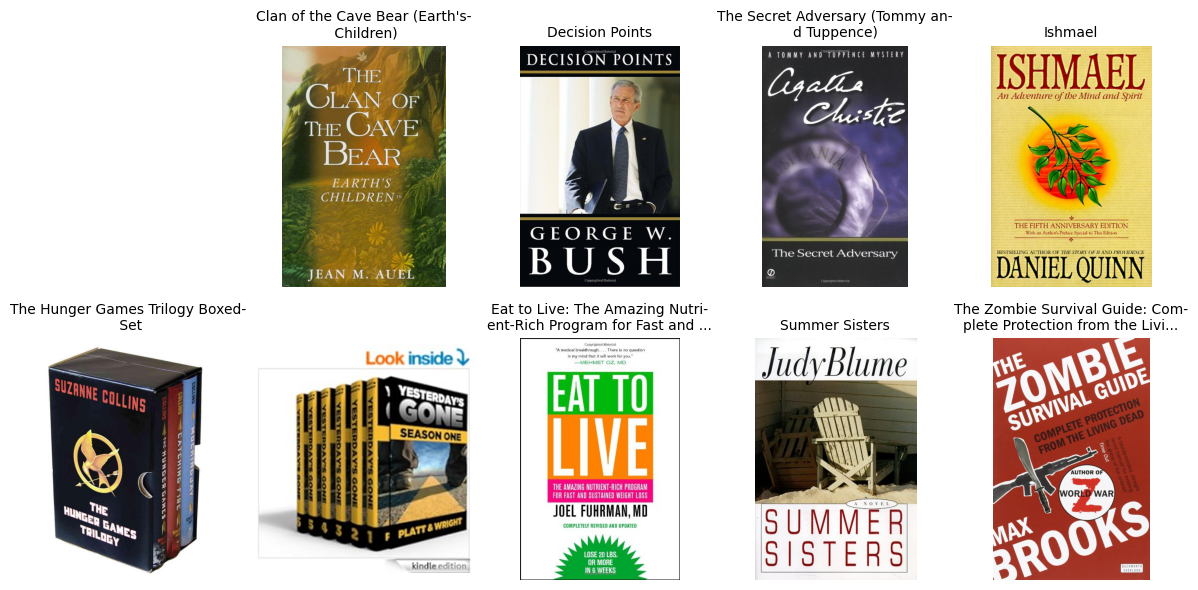

array([184887,  32022,  11259,  28782,  33303,  32652, 232540,  15780,
        21769,  38939], dtype=int32)

In [ ]:
recommend_Base(1003, visual=True)

[-0.79244461 -0.1340102  -0.1340102  ... -0.47349737 -0.62994051
  0.08494569]
[126816 111819 232131 202061 188998 149054 246866 246799 203577 162646]
User A2BNKCBBUAYAUT's last 10 purchased items: 


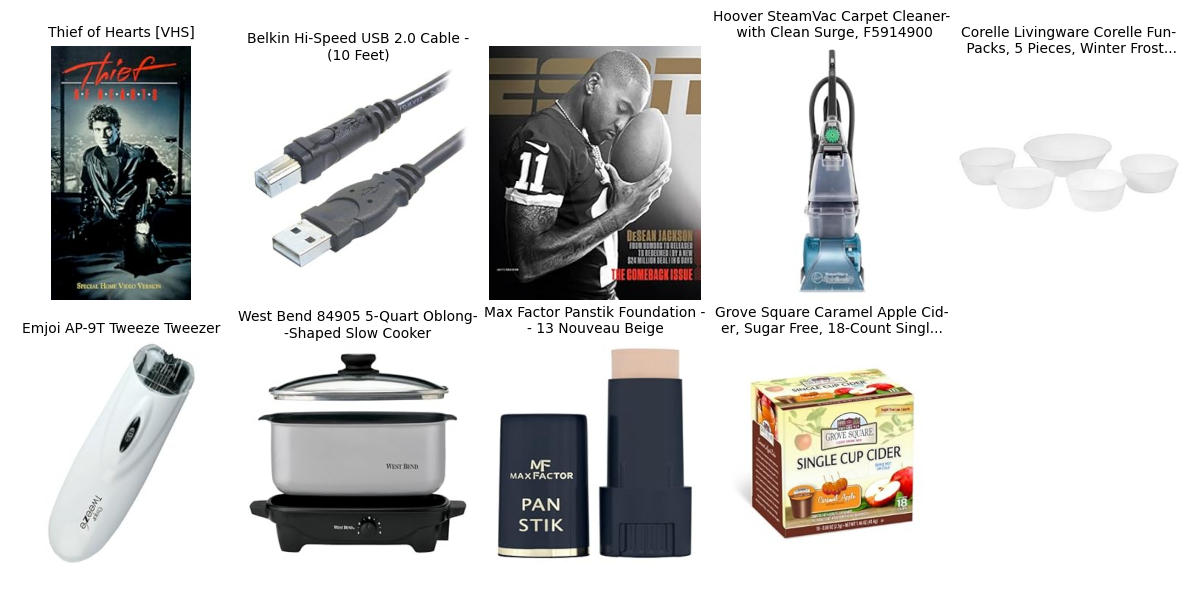

####################################################################################################
The top 10 recommended items: 


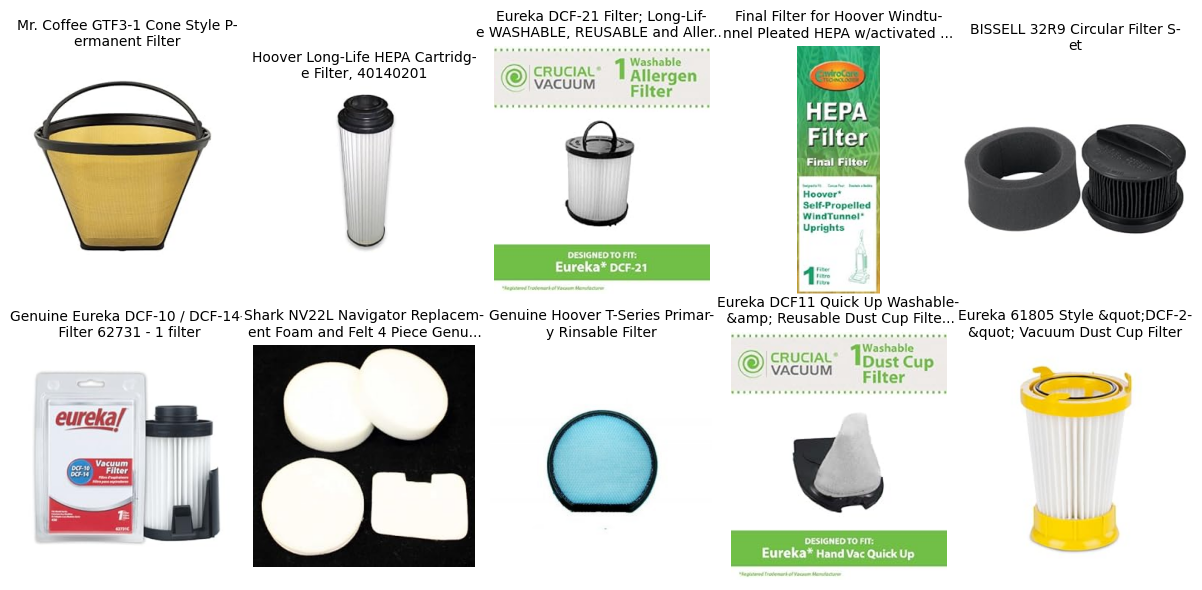

array([126816, 111819, 232131, 202061, 188998, 149054, 246866, 246799,
       203577, 162646])

In [ ]:
recommend_Sere(1003, lamb = 0, visual=True)

[-0.79244461 -0.1340102  -0.1340102  ... -0.47349737 -0.62994051
  0.08494569]
[236633 173146 204987 274440 180259 163575 164196 150304 124727 186141]
User A2BNKCBBUAYAUT's last 10 purchased items: 


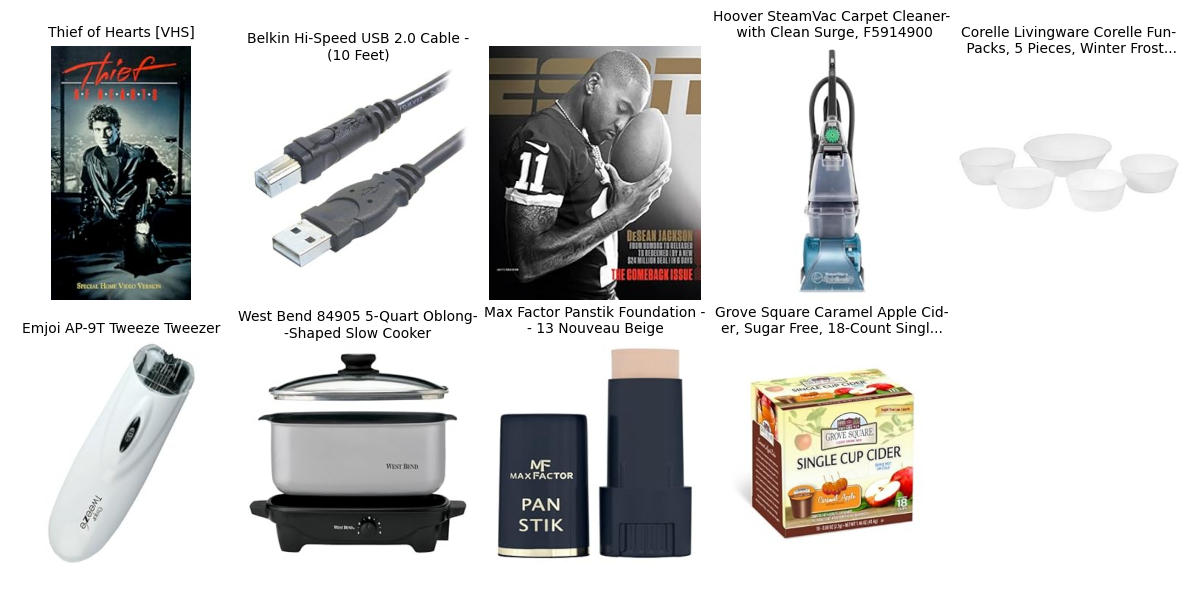

####################################################################################################
The top 10 recommended items: 


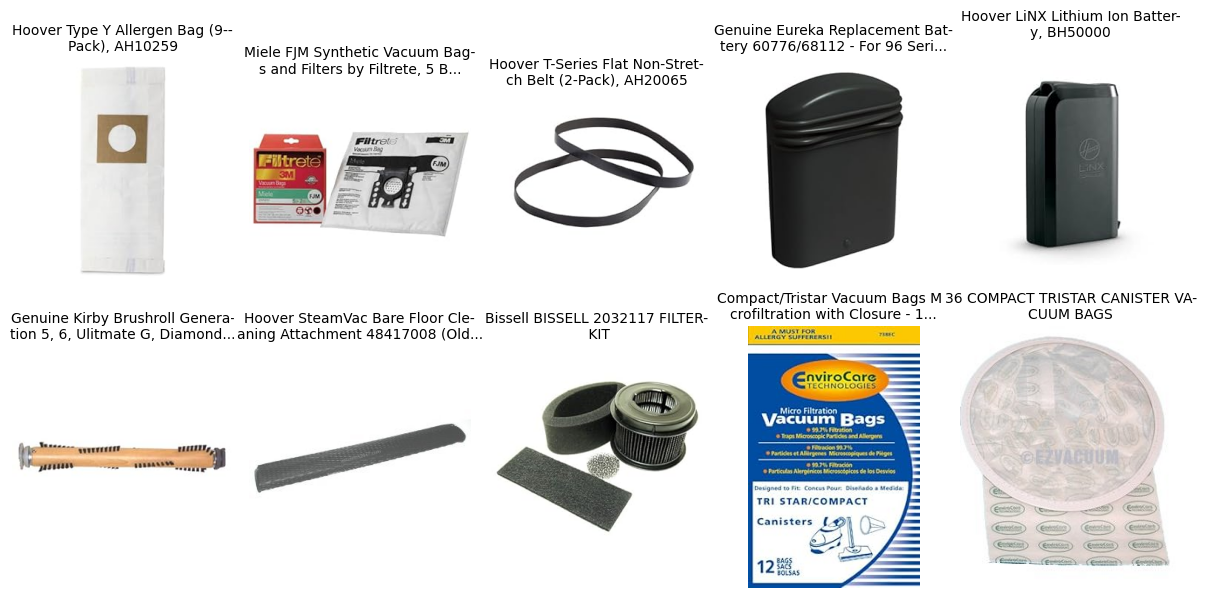

array([236633, 173146, 204987, 274440, 180259, 163575, 164196, 150304,
       124727, 186141])

In [ ]:
recommend_Sere(1003, lamb = 1, visual=True)

[-0.79244461 -0.1340102  -0.1340102  ... -0.47349737 -0.62994051
  0.08494569]
[ 57682  98083 153783  75476 289788  70128  36215 181301 146469  26265]
User A2BNKCBBUAYAUT's last 10 purchased items: 


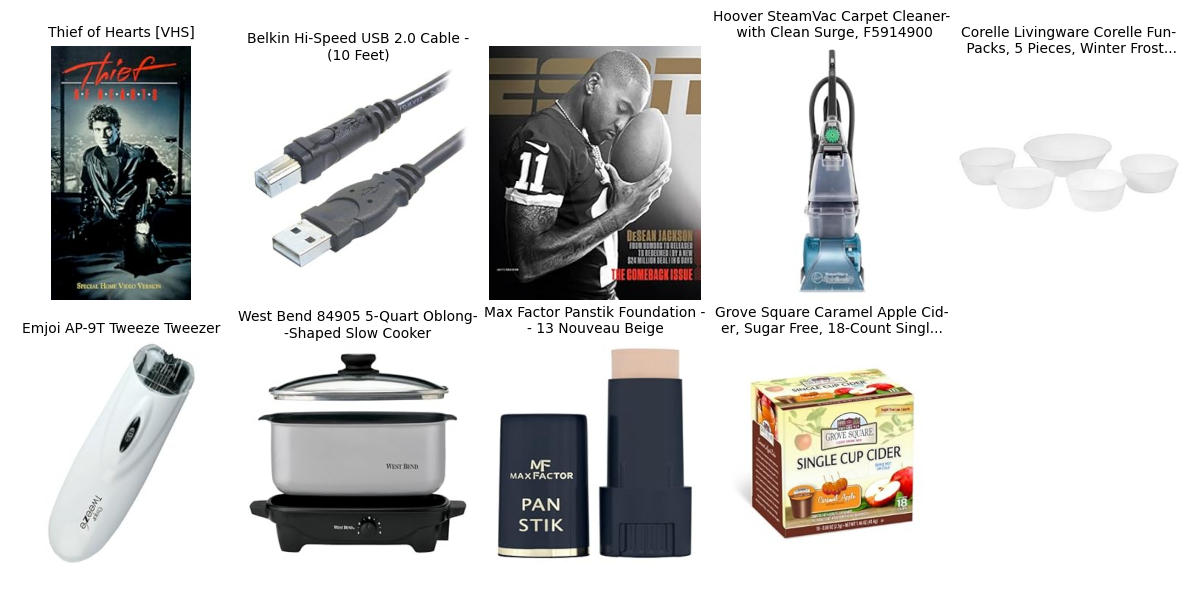

####################################################################################################
The top 10 recommended items: 


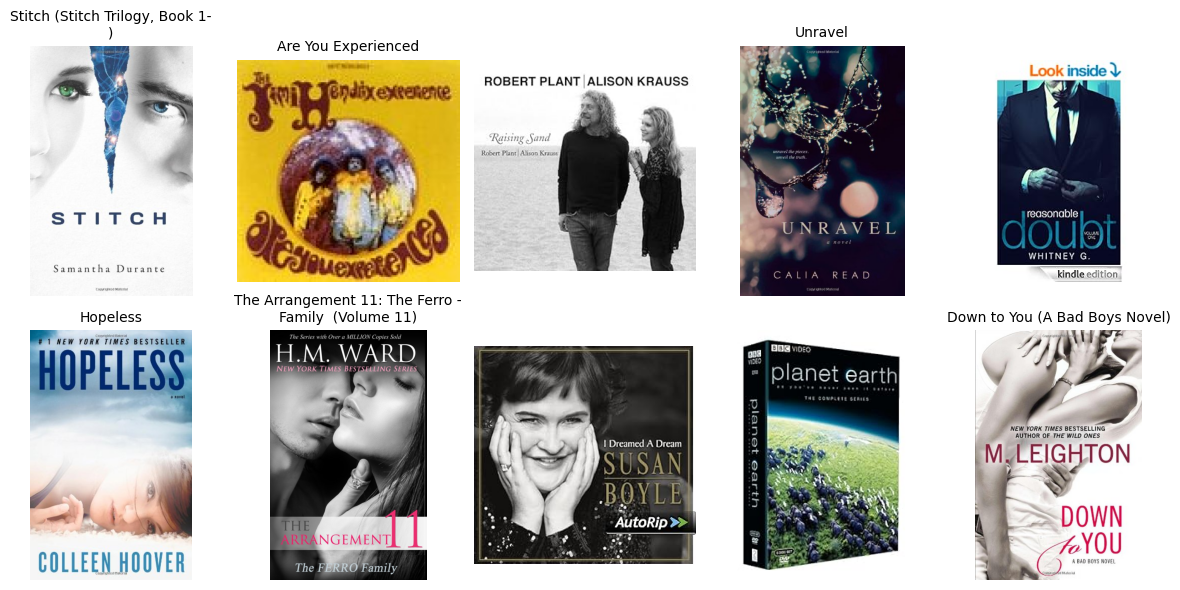

array([ 57682,  98083, 153783,  75476, 289788,  70128,  36215, 181301,
       146469,  26265])

In [ ]:
recommend_Sere(1003, lamb = 10, visual=True)

## Relevance

In [ ]:
def cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [ ]:
def cat2embeddings(cat_list):
    return np.stack([embedding_arr[c] for c in cat_list], axis=1)


In [ ]:
rec_em_Sere.shape

(10,)

In [ ]:
# E_target 1000x1 np.array
# E_matrix 1000x10 np.array
def relevance(E_target, E_matrix):
    sum = 0
    for i in range(10):
        sum += cosine_similarity(E_target,E_matrix[:,i])
    return sum/10

In [ ]:
# An example
user_id = 1003
rec_Sere = recommend_Sere(user_id)
rec_em_Sere = cat2embeddings(rec_Sere)
rec_Base = recommend_Base(user_id)
rec_em_Base = cat2embeddings(rec_Base)

target_em = np.array(get_embedding_from_cat_list(user_category_series[user_id][-1]))
relevance(target_em, rec_em_Sere), relevance(target_em, rec_em_Base)

(0.5077350269189627, 0.0)

In [ ]:
relevances_base = []
relevances_sere = []
for user_id in tqdm(np.random.choice(len(users), 100)):
    rec_Sere = recommend_Sere(user_id)
    rec_em_Sere = cat2embeddings(rec_Sere)
    rec_Base = recommend_Base(user_id)
    rec_em_Base = cat2embeddings(rec_Base)
    target_em = np.array(get_embedding_from_cat_list(user_category_series[user_id][-1]))
    rs, rb = relevance(target_em, rec_em_Sere), relevance(target_em, rec_em_Base)

    relevances_base.append(rb)
    relevances_sere.append(rs)

  3%|▎         | 3/100 [00:02<01:35,  1.02it/s]<ipython-input-222-5642eb8e43b8>:5: RuntimeWarning: invalid value encountered in double_scalars
  similarity = dot_product / (norm_a * norm_b)
100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


In [ ]:
relevances_base = np.nanmean(relevances_base)
relevances_sere = np.nanmean(relevances_sere)

In [ ]:
relevances_base, relevances_sere

(0.387442348943, 0.5077350269189627)

## Diversity

In [ ]:
def diversity(E_matrix):
    return np.mean(np.sum(E_matrix == 1, axis=0))

In [ ]:
diversity(rec_em_Sere), diversity(rec_em_Base)

(3.9, 1.0)

In [ ]:
diversity_base = []
diversity_sere = []
for user_id in tqdm(np.random.choice(len(users), 100)):
    rec_Sere = recommend_Sere(user_id)
    rec_em_Sere = cat2embeddings(rec_Sere)
    rec_Base = recommend_Base(user_id)
    rec_em_Base = cat2embeddings(rec_Base)

    target_em = np.array(get_embedding_from_cat_list(user_category_series[user_id][-1]))
    ds, db = diversity(rec_em_Sere), diversity(rec_em_Base)

    diversity_base.append(db)
    diversity_sere.append(ds)

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [ ]:
diversity_base = np.mean(diversity_base)
diversity_sere = np.mean(diversity_sere)

In [ ]:
diversity_base, diversity_sere

(2.562, 3.899999999999998)

## Unexpectedness

In [ ]:
# E_user_history 1000xt np.array, where t is the total items in the user's purchase history
# E_matrix 1000x10 np.array

def unexpectedness(E_user_history, E_matrix):
    # Calculate cosine similarity for each vector in E_matrix with all vectors in E_user_history
    avg_similarities = []
    for vector in E_matrix.T:  # Iterate through the columns of E_matrix (assuming it's shape is 1000x10)
        similarities = cosine_similarity(vector.reshape(1, -1), E_user_history.T).flatten()
        avg_similarities.append(np.mean(similarities))

    # Calculate the average of average similarities to get the final unexpectedness score
    familiarity = np.mean(avg_similarities)
    return 1 - familiarity


In [ ]:
unexpectedness_base = []
unexpectedness_sere = []
for user_id in tqdm(np.random.choice(len(users), 100)):
    cat_sequence = []
    for cat in user_category_series[user_id]:
        cat_sequence.append(get_embedding_from_cat_list(cat))
    cat_sequence = np.array(cat_sequence)
    rec_Sere = recommend_Sere(user_id)
    rec_em_Sere = cat2embeddings(rec_Sere)
    rec_Base = recommend_Base(user_id)
    rec_em_Base = cat2embeddings(rec_Base)
    ub, us = unexpectedness(cat_sequence.T, rec_em_Base), unexpectedness(cat_sequence.T, rec_em_Sere)

    unexpectedness_base.append(ub)
    unexpectedness_sere.append(us)


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


In [ ]:
unexpectedness_base = np.mean(unexpectedness_base)
unexpectedness_sere = np.mean(unexpectedness_sere)

In [ ]:
unexpectedness_sere, unexpectedness_base

(0.99820826046258, 0.8649733926057938)

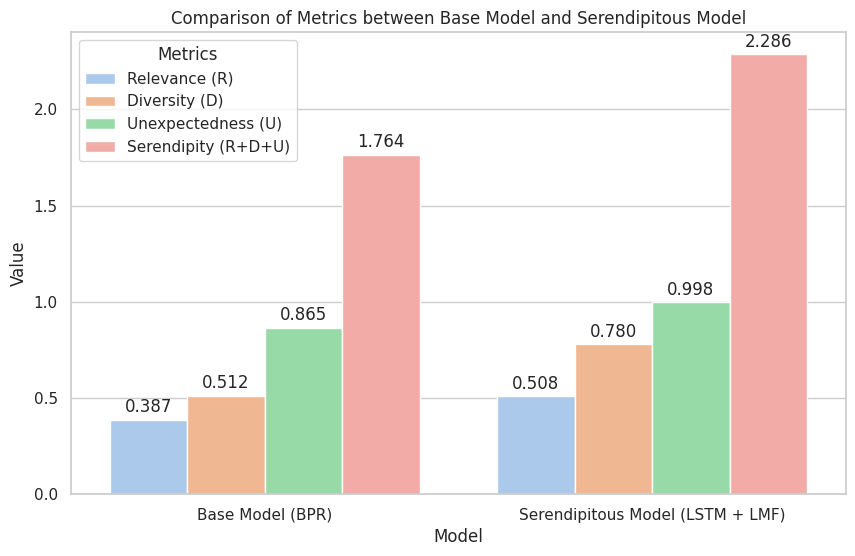

In [8]:

data = {
    "Model": ["Base Model (BPR)","Serendipitous Model (LSTM + LMF)"],
    "Relevance (R)": [relevances_base, relevances_sere],
    "Diversity (D)": [diversity_base/5, diversity_sere/5],
    "Unexpectedness (U)": [unexpectedness_base, unexpectedness_sere],
    "Serendipity (R+D+U)": [relevances_base+diversity_base/5+unexpectedness_base, relevances_sere+diversity_sere/5+unexpectedness_sere]
}

df = pd.DataFrame(data)
colors = sns.color_palette("pastel", 4)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="value", hue="variable", data=pd.melt(df, id_vars="Model"), palette=colors)
plt.xlabel("Model")
plt.ylabel("Value")
plt.title("Comparison of Metrics between Base Model and Serendipitous Model")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.legend(title="Metrics")
plt.savefig("fig.pdf", bbox_inches="tight",format="pdf")


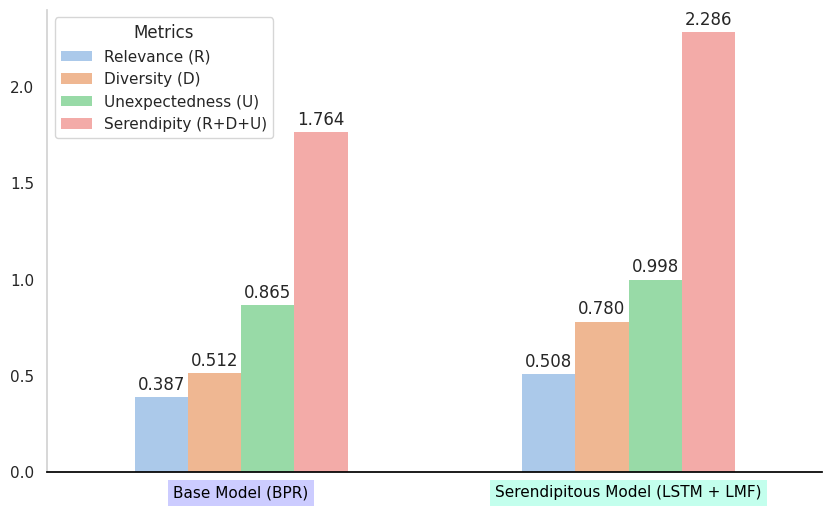

In [21]:

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="value", hue="variable", data=pd.melt(df, id_vars="Model"),
                 palette=colors, linewidth=0, width=0.55)  # Adding edge color

sns.despine()
ax.yaxis.grid(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('lightgray')
ax.set_yticks(np.arange(0,2.1,0.5))

ax.set_xlabel(None)
ax.set_ylabel(None)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.legend(title="Metrics")
for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
    if label.get_text() == "Base Model (BPR)":
        label.set_bbox({'facecolor': 'blue', 'alpha': 0.2, 'edgecolor': 'none'})
        label.set_color('black')  # Set text color to white
    elif label.get_text() == "Serendipitous Model (LSTM + LMF)":
        label.set_bbox({'facecolor': '#B5FFE9', 'alpha': 0.8, 'edgecolor': 'none'})
        label.set_color('black')  # Set text color to white

plt.savefig("fig.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
relevances_list = []
diversity_list = []
unexpectedness_list = []

lambda_values = [0, 0.5, 1, 2, 5, 10]

for lamb in lambda_values:

    relevances_sere = []
    diversity_sere = []
    unexpectedness_sere = []

    for user_id in tqdm(np.random.choice(len(users), 100)):

        rec_Sere = recommend_Sere(user_id, lamb = lamb)

        rec_em_Sere = cat2embeddings(rec_Sere)
        target_em = np.array(get_embedding_from_cat_list(user_category_series[user_id][-1]))

        rs = relevance(target_em, rec_em_Sere)

        relevances_sere.append(rs)

        ds = diversity(rec_em_Sere)

        diversity_sere.append(ds)

        cat_sequence = []
        for cat in user_category_series[user_id]:
            cat_sequence.append(get_embedding_from_cat_list(cat))
        cat_sequence = np.array(cat_sequence)

        us =  unexpectedness(cat_sequence, rec_em_Sere)

        unexpectedness_sere.append(us)

    relevances_list.append(np.nanmean(relevances_sere))
    diversity_list.append(np.mean(diversity_sere))
    unexpectedness_list.append(np.mean(unexpectedness_sere))

 67%|██████▋   | 67/100 [00:40<00:19,  1.73it/s]<ipython-input-314-5642eb8e43b8>:5: RuntimeWarning: invalid value encountered in double_scalars
  similarity = dot_product / (norm_a * norm_b)
100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [15]:
relevances_list

[0.49819572076271335,
 0.5132762035883011,
 0.4743003649363523,
 0.3219850127002913,
 0.013011674366489558,
 0.010647784120944012]

In [ ]:
diversity_list

[5.680999999999999,
 4.890000000000001,
 5.023000000000001,
 4.867000000000001,
 4.670000000000001,
 4.736000000000001]

In [ ]:
unexpectedness_list

[0.9872854109939986,
 0.9866194479837095,
 0.9918219869765786,
 0.9912895575549456,
 0.9996144384020481,
 0.9995401919712343]

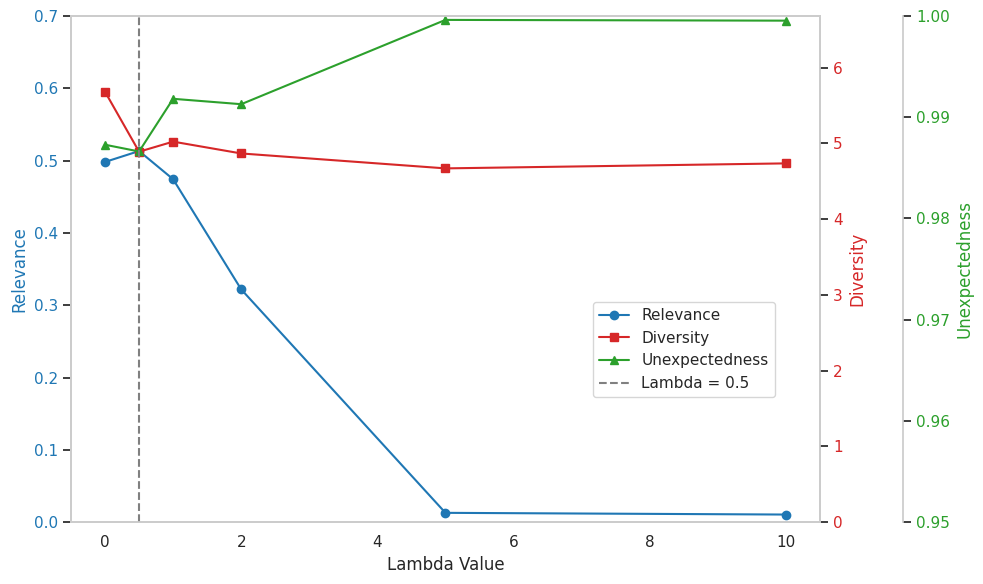

In [20]:

fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('Lambda Value')
ax1.set_ylabel('Relevance', color=color)
ax1.plot(lambda_values, relevances_list, marker='o', color=color, label='Relevance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.7)  

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Diversity', color=color)
ax2.plot(lambda_values, diversity_list, marker='s', color=color, label='Diversity')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(diversity_list) + 1)  

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  
color = 'tab:green'
ax3.set_ylabel('Unexpectedness', color=color)
ax3.plot(lambda_values, unexpectedness_list, marker='^', color=color, label='Unexpectedness')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(0.95, 1.0)  
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

# Show a vertical line at lambda = 0.5
ax3.axvline(x=0.5, color='gray', linestyle='--', label='Lambda = 0.5')

lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, bbox_to_anchor=(0.95, 0.45))

plt.xlabel('Lambda Values')
plt.tight_layout()
plt.savefig('effect_of_lambda_metrics.pdf', format='pdf', bbox_inches='tight')
plt.show()
